In [2]:
#load pacakages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [3]:
#access data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/695 project/cleaned_fraud_dataset.csv'
df = pd.read_csv(file_path)


In [5]:
#drop not useful columns
df_clean = df.select_dtypes(include=['number', 'bool']).copy()
#split data
X = df_clean.drop(['is_fraud'], axis=1, errors='ignore')
y = df_clean['is_fraud']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(430927, 4)

In [8]:
X_test.shape

(107732, 4)

In [9]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_test).value_counts(normalize=True))

is_fraud
False    0.666728
True     0.333272
Name: proportion, dtype: float64
is_fraud
False    0.666422
True     0.333578
Name: proportion, dtype: float64


In [10]:
# due to data imbalance fit random forest model with balanced data by using balanced
random_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
random_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_jobs=-1, random_state=42)

In [11]:
#check cv score
cv_scores = cross_val_score(random_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"Cross-Validation Scores: {cv_scores}")
print("Average F1 score:", cv_scores.mean())

Cross-Validation Scores: [0.36856099 0.38829203 0.37570495 0.36709569 0.38166525]
Average F1 score: 0.3762637825054008


In [12]:
#predict the result and check the result
y_pred = random_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
accuracy_score(y_test, y_pred)
print(f"Accuracy for First model: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

       False       0.67      0.55      0.60     71795
        True       0.34      0.45      0.39     35937

    accuracy                           0.52    107732
   macro avg       0.50      0.50      0.49    107732
weighted avg       0.56      0.52      0.53    107732

Accuracy for First model: 0.5182489882300524


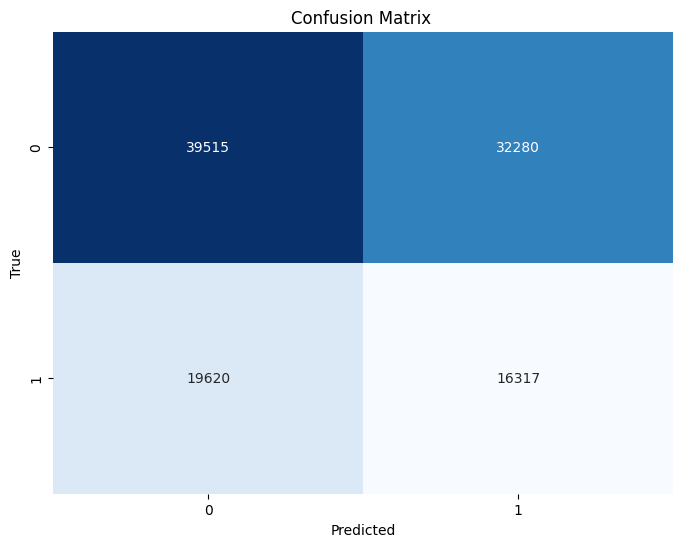

In [13]:

#cm for the first balanced model
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
#check features importance
importances = random_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

In [15]:
feature_importances_df.head()

,Feature,Importance
0,amount,0.372328
1,spending_deviation_score,0.296146
3,geo_anomaly_score,0.193887
2,velocity_score,0.137639


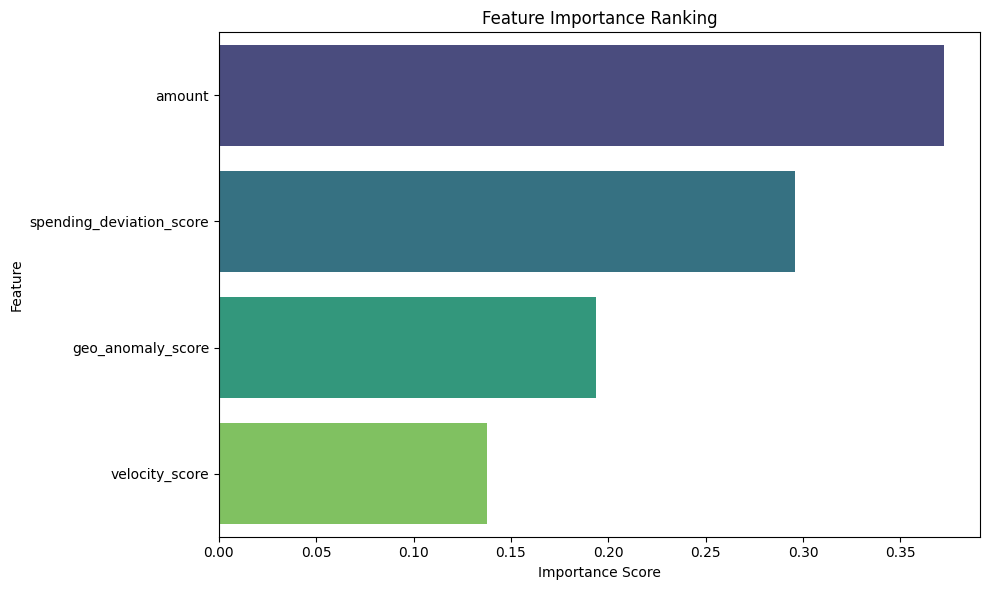

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [17]:
#check probability and auc
y_pred_proba = random_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

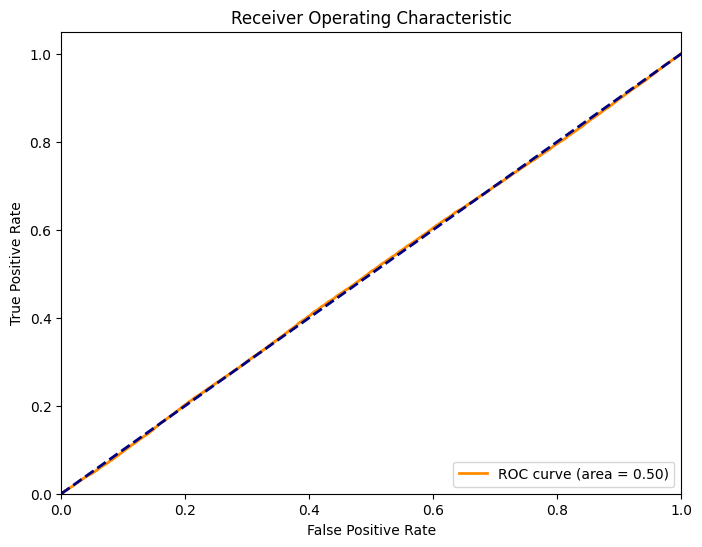

In [18]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [19]:
accuracy_score(y_test, y_pred)
print(f"Accuracy for First balanced model: {accuracy_score(y_test, y_pred)}")

Accuracy for First balanced model: 0.5182489882300524


Balance data by using SMOTE method to check if there is better perforamnce


In [18]:
# scale data
from imblearn.over_sampling import SMOTE


# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [21]:
## fit mode  with smote method
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [22]:
#cv socre for SMOTE method
cv_scores_smote = cross_val_score(rf_smote, X_train_smote, y_train_smote, cv=5, scoring='f1')
print(f"Cross-Validation Scores for Second model: {cv_scores_smote}")
print("Average F1 score for Second balance model :", cv_scores_smote.mean())

Cross-Validation Scores for Second model: [0.58958323 0.58639906 0.65367995 0.71502044 0.71271258]
Average F1 score for Second balance model : 0.6514790510801859


In [23]:
## prediction for second model
y_pred_smote= rf_smote.predict(X_test_scaled)
print(classification_report(y_test, y_pred_smote))
accuracy_score(y_test, y_pred_smote)
print(f"Accuracy for Second model: {accuracy_score(y_test, y_pred_smote)}")

              precision    recall  f1-score   support

       False       0.66      0.28      0.40     71795
        True       0.33      0.71      0.45     35937

    accuracy                           0.43    107732
   macro avg       0.50      0.50      0.43    107732
weighted avg       0.55      0.43      0.42    107732

Accuracy for Second model: 0.4270783054245721


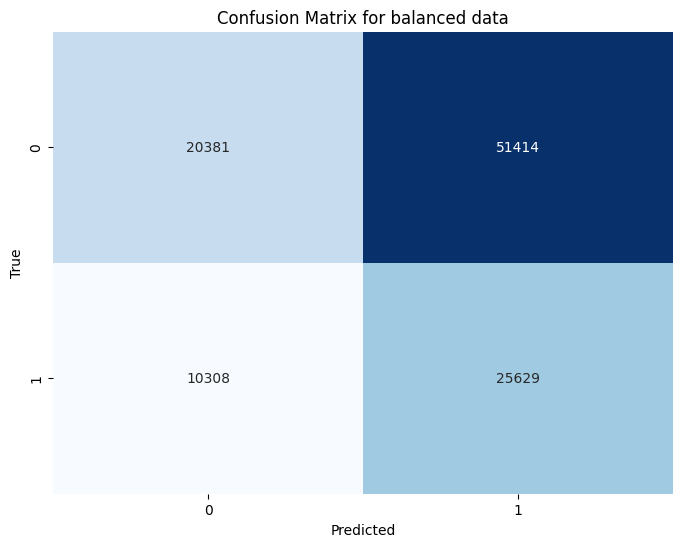

In [25]:
## cm for second model

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for balanced data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# probability and auc for second model
y_pred_proba_smote = rf_smote.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_smote)
roc_auc = auc(fpr, tpr)


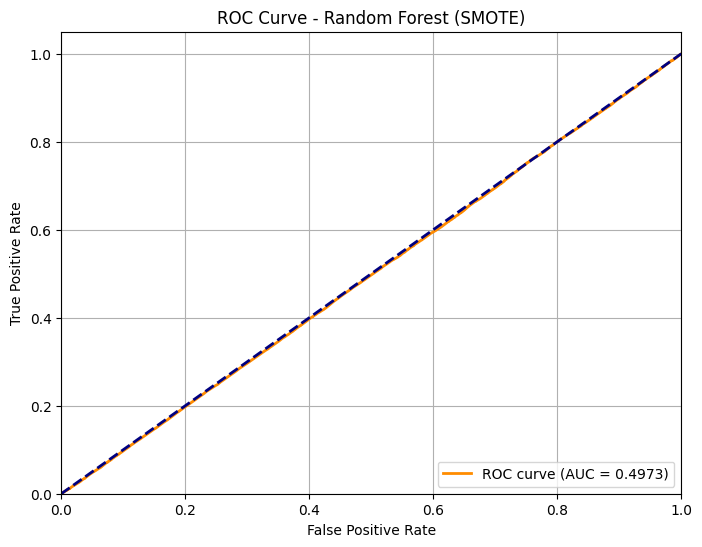

In [27]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
#check features importance
importances = rf_smote.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

In [29]:
feature_importances_df.head()

,Feature,Importance
3,geo_anomaly_score,0.760227
1,spending_deviation_score,0.121460
0,amount,0.089843
2,velocity_score,0.028470


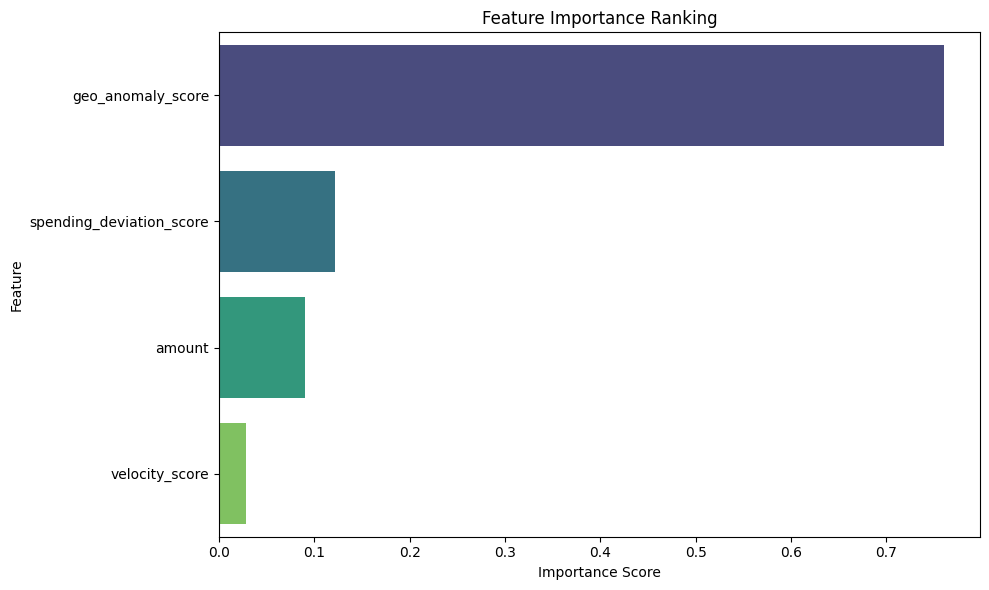

In [30]:
#plot importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

XGBOOST


In [31]:
!pip install xgboost

In [10]:
# trying for the XGBClassifier
# need to balanced the data as the model is not relaible when tested without imnblanced
# Calculate scale_pos_weight manually

from xgboost import XGBClassifier

xgmodel = XGBClassifier(tree_method='gpu_hist', predictor = 'gpu_predictor',
                        n_estimators = 100, max_depth = 10, random_state = 42)
xgmodel.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
#cross validation
cv_scores_xg = cross_val_score(xgmodel, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"Cross-Validation Scores: {cv_scores_xg}")
print("Average F1 score for first XGBoost:", cv_scores_xg.mean())

Cross-Validation Scores: [0.07831807 0.07367314 0.07893445 0.07414953 0.07553924]
Average F1 score for first XGBoost: 0.07612288479638048


In [12]:
#predict xgboost model
y_pred_xg = xgmodel.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

       False       0.67      0.97      0.79     71795
        True       0.34      0.04      0.06     35937

    accuracy                           0.66    107732
   macro avg       0.50      0.50      0.43    107732
weighted avg       0.56      0.66      0.55    107732



In [13]:
accuracy_score(y_test, y_pred_xg)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xg)}")

Accuracy: 0.6553113281104964


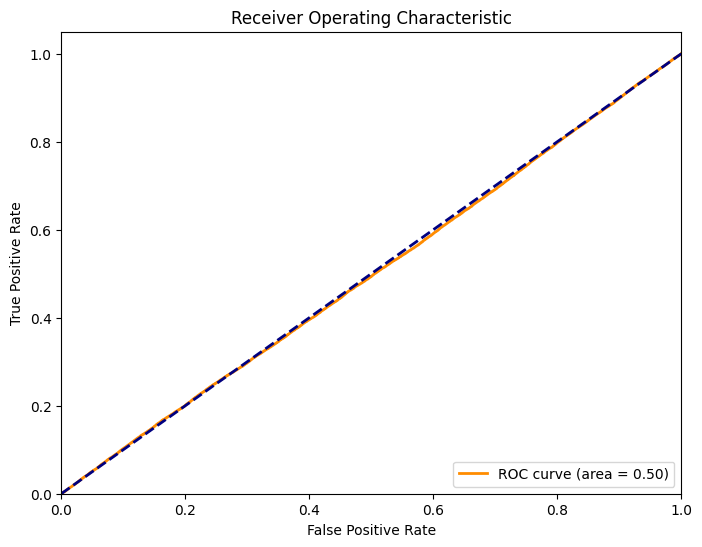

In [14]:
# Probabilities
y_prob_xg = xgmodel.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xg)
roc_auc_xg = auc(fpr, tpr)

# Plot

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xg)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [15]:
importances = xgmodel.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df.head()

,Feature,Importance
0,amount,0.252904
1,spending_deviation_score,0.252567
3,geo_anomaly_score,0.250298
2,velocity_score,0.244231


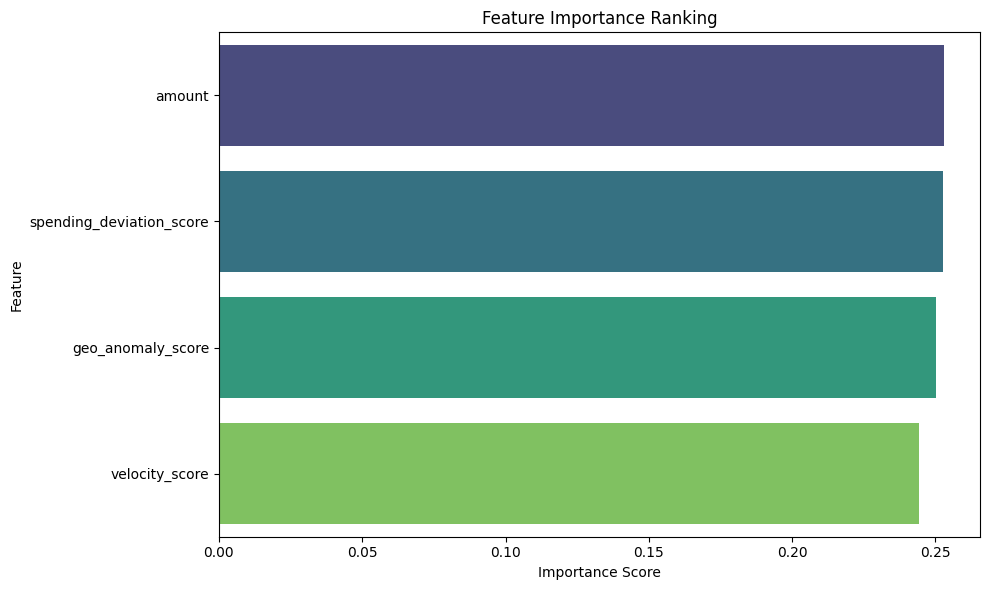

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Cross-Validation Scores: [0.00600352 0.00490179 0.00681936 0.0057967  0.00483693]
Average F1 score for first XGBoost: 0.005671658940804401
